# Project introduction

## Motivation

Robots that move in unstructured environments still face a gap between what they see and how they should act. Diffusion models offer a way to bridge that gap because they generate complex outputs through a sequence of small refinements, which makes them robust to distribution shift and naturally multimodal. In this project we apply a conditional diffusion model to robotic control. From a handful of recent camera frames the policy should output a smooth two-dimensional trajectory for the robot end-effector that reaches a goal in a simulated plane. The broader aim is to keep the architecture so general that retraining on another state space—joint angles, 3-D Cartesian poses, or even a completely different task—requires almost no code changes.

## Problem statement

During training we observe expert demonstrations. Each demonstration supplies a stack of $K$ RGB frames and a ground-truth end-effector path of length $T$ in the plane. At test time the policy sees new frames and must produce a feasible path that completes the task despite novel object layouts and lighting. The current focus is two-dimensional tabletop manipulation, but the same network can be re-used for other robots or higher-dimensional workspaces after retraining.

## Approach in brief

A one-dimensional U-Net operates in trajectory space. To train it we add Gaussian noise to the expert path according to the forward diffusion distribution $q(a_t\mid a_0)$. The network receives that noisy path, a sinusoidal embedding that codes only the diffusion step index $t$ (not the images), and a visual context vector $g$ extracted from the image stack. It predicts the noise component $\hat\varepsilon$ and is optimised with the mean-squared error $\|\varepsilon-\hat\varepsilon\|^2$. At inference we start from pure Gaussian noise and iterate the learned reverse process until we recover a clean end-effector path.

## High-level pipeline

Raw frames pass through a visual encoder to obtain the latent vector $g$. A positional module turns the diffusion step $t$ into a sine-cosine code, and the concatenation $[p_t;g]$ conditions every residual block in the U-Net through FiLM. Convolutions run along the temporal axis of the trajectory, with down- and up-sampling providing a wide receptive field at modest cost. The final convolution maps features to the two Cartesian action channels $(x, y)$. A scheduler then converts the predicted noise into the next cleaner trajectory sample.

## Expected outcomes

The policy should produce end-effector paths that are dynamically consistent, visually grounded, and more robust than one-shot regression baselines. Because the positional embedding is tied only to the diffusion step and the U-Net is agnostic to how many channels the action space holds, the same code base can tackle joint-space control, 3-D positioning, or alternate robots by retraining on new demonstrations.

## Roadmap and current status

### Done:
- Diffusion Models theory
- Dataset structure and Class
- Expert demonstrations collection setup
- Visual Encoder
- Sinusoidal step embeddings
- Convolutional and residual blocks


The next milestones are FiLM integration, full U-Net assembly, and evaluation on both transformer- and CNN-based visual encoders. Once these parts are finished we will run large-scale training in a 2-D simulator, followed by transfer tests to more complex state spaces without modifying the core architecture.

# Diffusion Models

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_swiss_roll
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
device = torch.device("cuda")

## Data

In this example notebook we will use the Swiss Roll points distribution, and take only $R^2$ version of it.
The loaded data is normilized for stability during training and puted into the `Dataset` class to later use the `DataLoader` that manage batching and shuffling.

In [4]:
def load_swiss_roll_data(n_samples=400, noise=0.2):
    data, _ = make_swiss_roll(n_samples=n_samples, noise=noise)
    data_2d = data[:, [0, 2]]
    data_tensor = torch.tensor(data_2d, dtype=torch.float32)
    data_tensor = (data_tensor - data_tensor.mean(dim=0)) / data_tensor.std(dim=0)
    return data_tensor

class SwissRollDataset(Dataset):
    def __init__(self, n_samples=400, noise=0.2):
        self.data = load_swiss_roll_data(n_samples=n_samples, noise=noise)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]


def plot_data_points(all_data_tensor, draw_samples=None, ax = None):
    """
    Visualizes 2D data points.

    Parameters:
      - all_data_tensor: torch.Tensor of shape [N, 2] containing the main data points.
      - draw_samples: torch.Tensor or None of shape [M, 2] containing additional points to highlight (plotted in green).
      - ax: matplotlib axes object
    """
    data_np = all_data_tensor.detach().cpu().numpy()

    canvas = ax if ax is not None else plt.gca()

    if draw_samples is not None:
        draw_samples_np = draw_samples.detach().cpu().numpy()
    else:
        draw_samples_np = None

    alpha_value = 0.2 if draw_samples_np is not None else 1.0
    canvas.scatter(data_np[:, 0], data_np[:, 1], alpha=alpha_value)

    if draw_samples_np is not None:
        canvas.scatter(draw_samples_np[:, 0], draw_samples_np[:, 1], c="purple")

    canvas.set_xticks([])
    canvas.set_yticks([])

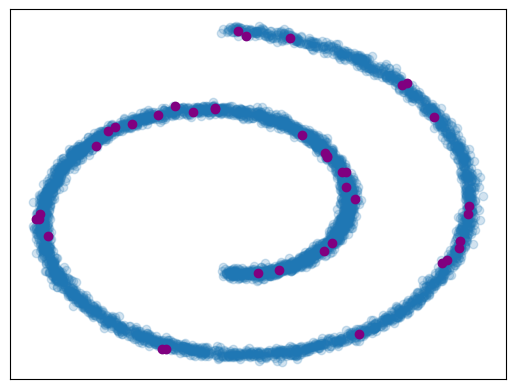

In [6]:
data = SwissRollDataset(n_samples=5000, noise=0.2)

train_size = int(0.8 * len(data))
test_size = len(data) - train_size

train_dataset, test_dataset = random_split(data, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

plot_data_points(data[:], data[0:40])

## Diffusion model details

Originally the diffusion model is idea, that came from statistical physics, in the domain of Machine Learning this is class of generative models. Initially it was introduced to generate images and performed good beating some of the traditional approaches like GAN and VAEs, during this explanantion block I will consider reviewing the case of image generation, but during the implementation and in Future Work section also will be covered how these kind of models perform on other modalities. The idea of training approach consist of 2 main steps:

## Forward Pass
On the high level the forward pass is the process that takes item $x_{t-1}$ at time step $t-1$ and produced the more noisy version of it $x_t$:
$$
q(x_t \mid x_{t-1}) = \mathcal{N}\Bigl(x_t; \sqrt{1-\beta_t}\, x_{t-1},\, \beta_t I\Bigr)
$$

So $q$ here is PDF, which is described by parametrized Gaussian Distribution, that is used to sample the value of each pixel at next time step.
On the interpretation level, using the scheduler $\beta$ the function is described:
1. *Mean*: Gradually decrease the mean with factor $\sqrt{\beta_t - 1}$, this means that the significance of the main signal is reduced every timestep;
2. *Variance*: Described with covariation matrix $\beta_t I$, where $I$ is one matrix for $R^{dim}$, this means noisy is added independently to each value of the input.

By applying this stochastic transformation for large number of times, we arrive to the point where initial signal is just Gaussian Noise.

### Implemenation trick

Mostly while working with diffusion models we want to compute noisy image $x_t$ at time step $t$ given the original input $x_0$, of course we could just chain the computations and iteratively arrive to the desired timestep:

$$
\begin{aligned}
x_1 &= \sqrt{1-\beta_1}\, x_0 + \sqrt{\beta_1}\,\epsilon_1, \quad \epsilon_1 \sim \mathcal{N}(0, I) \\
x_2 &= \sqrt{1-\beta_2}\, x_1 + \sqrt{\beta_2}\,\epsilon_2, \quad \epsilon_2 \sim \mathcal{N}(0, I) \\
&\ \, \vdots \\
x_t &= \sqrt{1-\beta_t}\, x_{t-1} + \sqrt{\beta_t}\,\epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, I)
\end{aligned}
$$

However, there is the trick that allows to come up with the image $x_t$ directly given the $x_0$:

$$
\begin{aligned}
q(x_t | x_0) = \sqrt{\bar{\alpha}_t}\cdot x_0 + \sqrt{1 - \bar{\alpha}_t}, \quad \text{where } \quad
\alpha_t = 1 - \beta_t\\
\bar{\alpha}_t = \prod_{i=1}^{n} a_i\\
\end{aligned}
$$

In the following math part the formula is derived, also the explanation of the new concept I learned during that called reparameterization trick:

<img alt="Описание изображения" src="math_img/forward_chain_p1.jpeg" width="600"/>

<img alt="Описание изображения" src="math_img/forward_chain_p2.jpeg" width="600"/>

<img alt="Описание изображения" src="math_img/reparametrizstion_trick.jpeg" width="600"/>


## Diffusion Scheduler

Scheduler is important part of the diffusion networks, it is used to control the speed and "shape" of the noising process, for example:

1. **Linear Scheduler**
   - **Description:** The noise variance (β) increases linearly over time.
   - **Theory:** With a linear schedule, each timestep adds a fixed increment of noise, making the process simple to implement. It works well when the diffusion process needs a constant rate of degradation.

2. **Cosine Scheduler**
   - **Description:** Uses a cosine function to schedule noise variance.
   - **Theory:** A cosine scheduler adjusts the noise levels more gradually at the beginning and end of the diffusion process. This can help in preserving fine details early on and allows for smoother transitions later.

3. **Quadratic Scheduler**
   - **Description:** The noise variance increases quadratically with time.
   - **Theory:** In a quadratic schedule, noise starts growing slowly at first and then increases more rapidly. This can be useful when initial timesteps should retain more of the original signal while later timesteps rapidly add noise.

4. **Exponential Scheduler**
   - **Description:** The noise variance increases exponentially over time.
   - **Theory:** This scheduler adds little noise in the early stages and then rapidly increases the noise later. It is useful if you want the early diffusion process to be almost deterministic and introduce randomness primarily in later steps.

5. **Custom Scheduler**
   - **Description:** Any user-defined schedule that fits specific requirements.
   - **Theory:** Depending on the dataset or application, custom schedules can be designed to control the "shape" of the noise addition. For instance, a scheduler might use a piecewise function that is linear in one interval and cosine in another.

In this notebook the Linear scheduler will be used, but it is easily replacable by defining  the abstract scheduler class.


In [7]:
from abc import ABC, abstractmethod
import torch

class BaseDiffusionSchedule(ABC):
    @abstractmethod
    def __init__(self, timesteps, beta_start=0.0001, beta_end=0.02):
        """
        Abstract base class for diffusion schedules.
        Should be defined by subclasses.:
          - sqrt_alphas_cumprod,
          - sqrt_one_minus_alphas_cumprod.
        """
        pass

    @abstractmethod
    def get_index(self, t):
        """
        Abstract method that returns (sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod) for the time step t.

        Params:
        - t: time step,

        Returns:
            (sqrt alphas cumprod at t, sqrt one minus alphas cumprod at t)
        """
        pass


class LinearDiffusionSchedule(BaseDiffusionSchedule):
    def __init__(self, timesteps, beta_start=0.0001, beta_end=0.02, device='mps'):
        self.timesteps = timesteps
        self.betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)

    def get_index(self, t):
        return self.sqrt_alphas_cumprod[t], self.sqrt_one_minus_alphas_cumprod[t]


In [9]:
noise_scheduler = LinearDiffusionSchedule(100, device=device)

first = noise_scheduler.get_index(4)

first

(tensor(0.9987, device='cuda:0'), tensor(0.0501, device='cuda:0'))

## Forward Diffusion Sample
This function just applies the formula derived in the math block that produces $x_t | x_0$:
$$
q(x_t \mid x_0) = \sqrt{\bar{\alpha}_t}\, x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon, \quad \text{where } \epsilon \sim \mathcal{N}(0, I)
$$


In [10]:
def forward_diffusion_sample(x_0, t):
    """
    Takes the origial state of the vector and add noise to it accordingly to the timestep t.

    Params:
    - x_0: torch tensor 2d
    - t: time step,

    Returns:
        The noisy version of vector at timestep t,
    """
    noise = torch.randn_like(x_0, device=device)
    sqrt_alphas_cumprod_t = noise_scheduler.sqrt_alphas_cumprod[t]
    sqrt_one_minus_alphas_cumprod_t = noise_scheduler.sqrt_one_minus_alphas_cumprod[t]
    noisy = sqrt_alphas_cumprod_t * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t * noise
    return noisy, noise

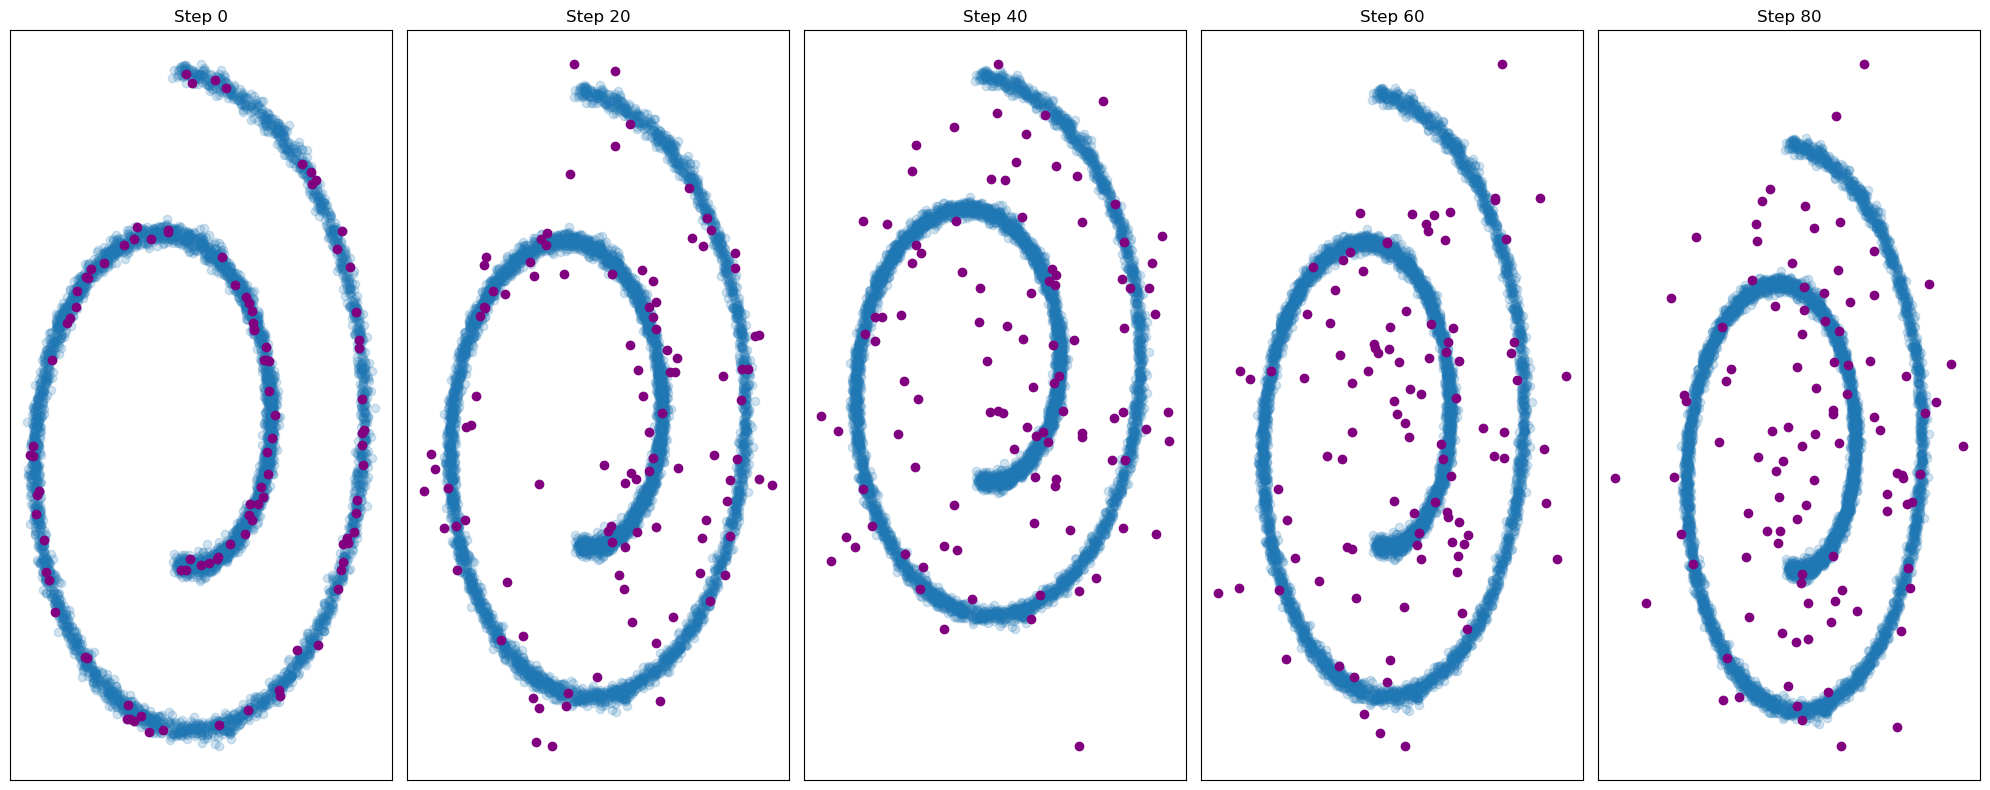

In [11]:
test_vecs = data[0:100]

test_vecs_display = test_vecs.clone()

timesteps = torch.arange(100)

k = 20

fig, axes = plt.subplots(1, len(timesteps) // k, figsize=(20, min(8, 2 * k)))

for i, timestep in enumerate(timesteps):
    if  i % k == 0:
        ax = axes[i // k]
        ax.set_title(f"Step {timestep.item()}")
        plot_data_points(data[:], test_vecs_display, ax)

    test_vecs_display = forward_diffusion_sample(test_vecs, timestep)[0]

plt.tight_layout()
plt.show()


Note even though here we iterate over every value of $t$, you could see that the function is called without need of previous timestep. This is just to show the graduall process how points are distorted.

## Basic ANN for noise estimation

In [15]:
import random

class NoiseEstimator(nn.Module):
    def __init__(self, input_dim, timestep_dim):
        super(NoiseEstimator, self).__init__()

        self.time_embedding = nn.Sequential(
            nn.Linear(1, timestep_dim),
            nn.ReLU(),
            nn.Linear(timestep_dim, timestep_dim)
        ).to(device)

        self.model = nn.Sequential(
            nn.Linear(input_dim + timestep_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        ).to(device)


    def forward(self, data, timestep):
        time_step = torch.full((data.shape[0], 1), float(timestep), dtype=torch.float, device=data.device)
        t_emb = self.time_embedding(time_step)
        x_input = torch.cat([data, t_emb], dim=1)
        noise_pred = self.model(x_input)
        return noise_pred

## Train

In [18]:
def train(model, data_loader, optimizer, epochs=100):
    model.train()
    epoch_loss = []
    for epoch in range(epochs):

        acc_loss = 0

        for batch_idx, data in enumerate(data_loader):
            data = data.to(device)

            timestep = random.randint(0, noise_scheduler.timesteps-1)

            noised_vectors, actual_noise = forward_diffusion_sample(data, timestep)

            predicted_noise = model(noised_vectors, timestep)

            loss = F.mse_loss(predicted_noise, actual_noise)

            acc_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Loss = {acc_loss / (len(data_loader) * data_loader.batch_size) :.4f}")
        epoch_loss.append(np.mean(acc_loss))

        plt.plot(epoch_loss)

Epoch 0: Loss = 0.0159
Epoch 50: Loss = 0.0114
Epoch 100: Loss = 0.0100
Epoch 150: Loss = 0.0097
Epoch 200: Loss = 0.0095
Epoch 250: Loss = 0.0095
Epoch 300: Loss = 0.0095
Epoch 350: Loss = 0.0093


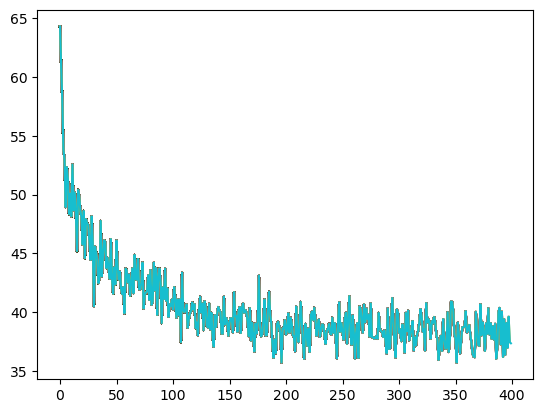

In [19]:
noise_model = NoiseEstimator(input_dim=2, timestep_dim=16)
optimizer_instance = torch.optim.Adam(noise_model.parameters(), lr=0.001)
train_acc = train(noise_model, train_loader, epochs=400, optimizer=optimizer_instance)

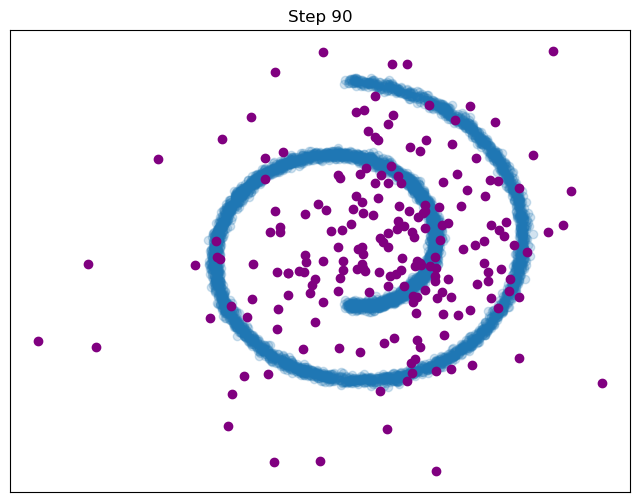

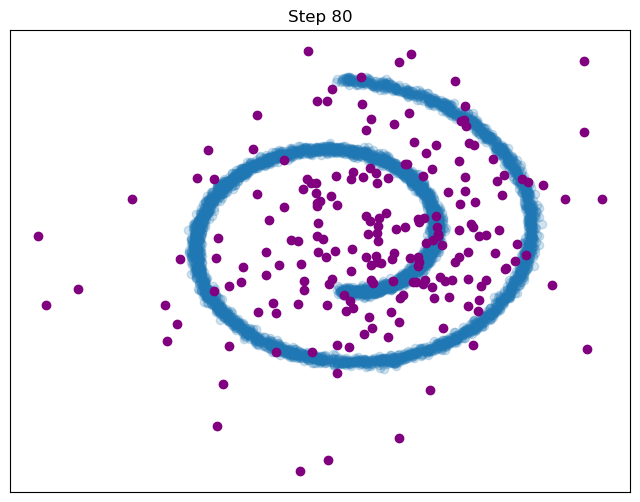

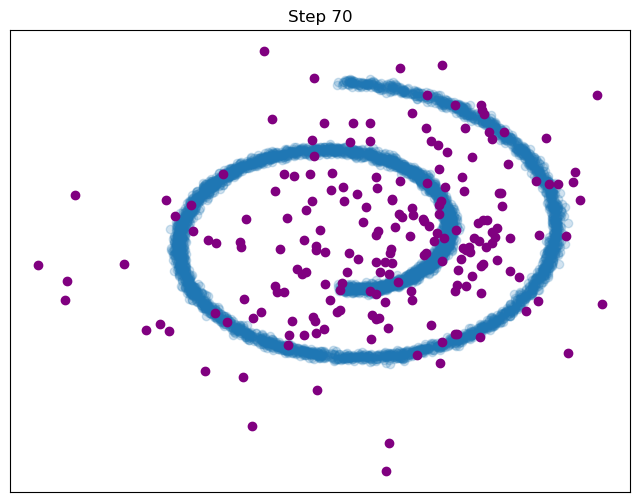

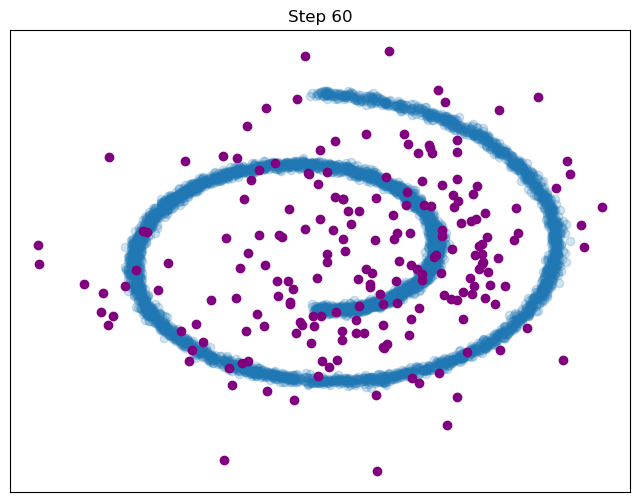

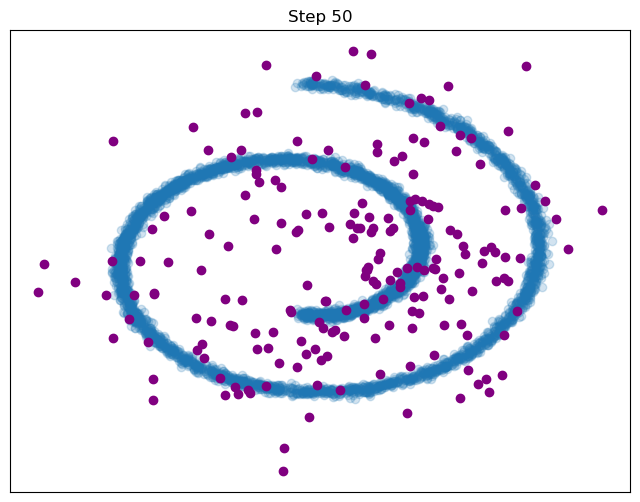

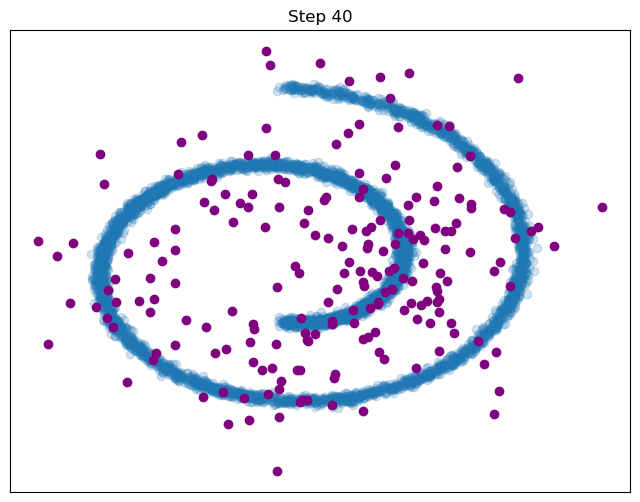

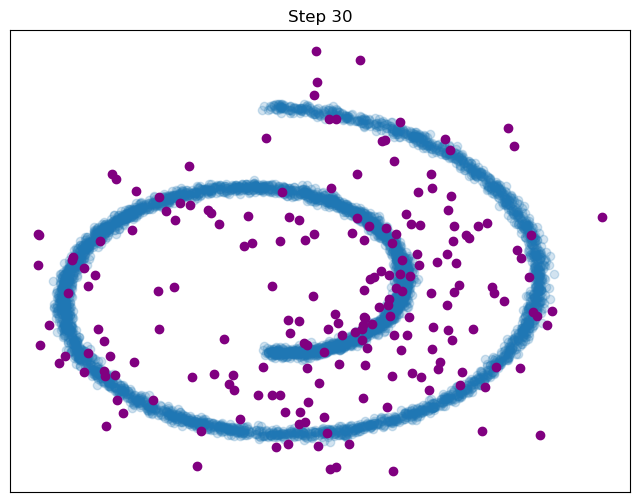

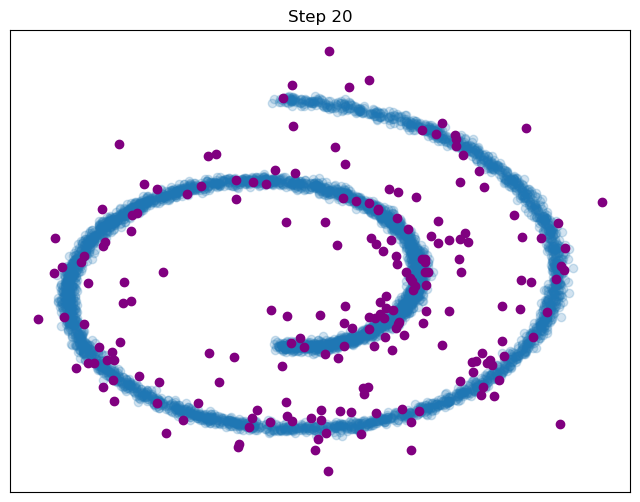

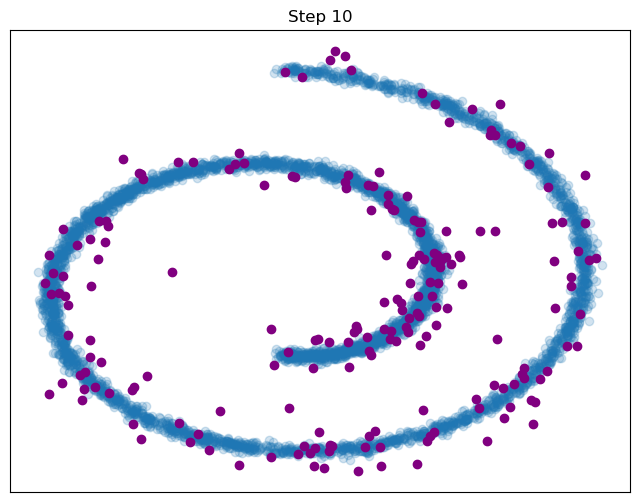

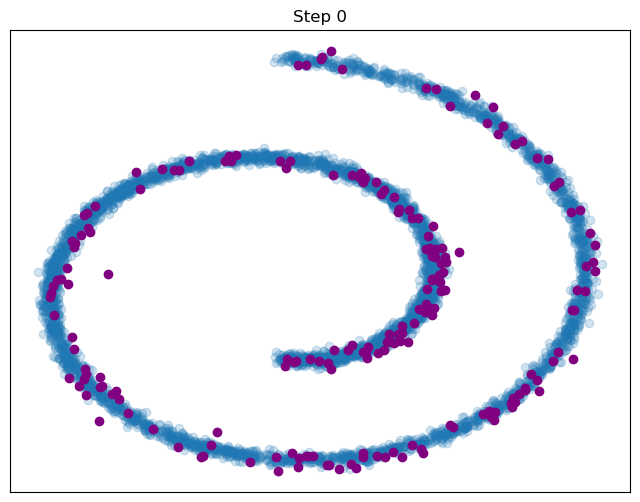

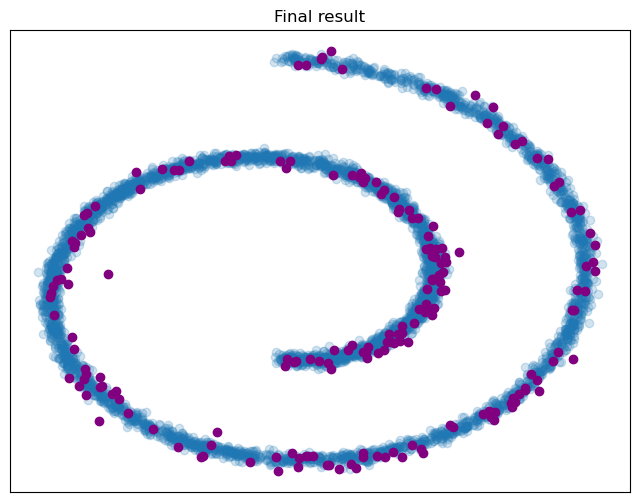

In [20]:
@torch.no_grad()
def reverse_diffusion_sample(model, noise_scheduler, shape, period = 1, device='mps'):
    """
    Generates data using the reverse diffusion process.

    Parameters:
      - model: The noise prediction model.
      - noise_scheduler: Object containing betas, alphas, and alphas_cumprod.
      - shape: Shape of the generated data (e.g., [batch_size, 2]).
      - device: Device to run the computations on.

    Returns:
      - x: Generated data tensor.
    """
    # Start from pure noise
    x = torch.randn(shape, device=device)

    for t in reversed(range(noise_scheduler.timesteps)):
        # Predict the noise component using the model
        pred_noise = model(x, t)

        beta_t = noise_scheduler.betas[t]
        alpha_t = noise_scheduler.alphas[t]
        alpha_bar_t = noise_scheduler.alphas_cumprod[t]
        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)

        # Compute the mean of the reverse process distribution:
        mean = (x - (beta_t / sqrt_one_minus_alpha_bar_t) * pred_noise) / sqrt_alpha_t

        if t > 0:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(beta_t)
            # Update x_t to x_{t-1}
            x = mean + sigma_t * noise
        else:
            x = mean

        if t % period == 0:
            plt.figure(figsize=(8, 6))
            plot_data_points(data[:], x)
            plt.title(f"Step {t}")
            plt.show()

    plt.figure(figsize=(8, 6))
    plot_data_points(data[:], x)
    plt.title("Final result")
    plt.show()



eval_vecs = torch.randn((2000,2)).to(device) * 2

reverse_diffusion_sample(noise_model, noise_scheduler, (200,2), period=10, device=device)

# Dataset

## Zarr Dataset structure

In [22]:
import zarr

dataset = zarr.open("../data/demonstrations_snapshot_1.zarr", mode="r")

In [23]:
data = dataset["data"]
imgs = data["img"][:]
actions = data["action"][:]
episode_ends = dataset["episode_ends"][:]

Length of images: 9086
Action shape: (2,)
Length of actions: 9086
Image shape: (224, 224, 3)
Length of episode_ends: 54


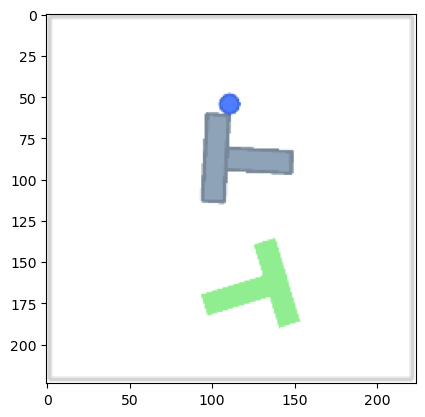

In [24]:
print(f"Length of images: {len(imgs)}")
print(f"Action shape: {actions[0].shape}")
print(f"Length of actions: {len(actions)}")
print(f"Image shape: {imgs[0].shape}")
print(f"Length of episode_ends: {len(episode_ends)}")

img = imgs[340]
plt.imshow(img/ 255)

## Understanding of dataset

* **actions**
  `[1,3,5,2,1,7,9,4,3,2]`
* **images**
  `[img1,img2,img3,img4,img5,img6,img7,img8,img9,img10]`

#### Proper `episode_ends` array

The recording code appends **cumulative** episode lengths.
With three episodes of lengths

* episode1=4 steps
* episode2=4 steps
* episode3=2 steps

we get:

```python
episode_ends = [0, 4, 8, 10]
```

#### Split

| Episode | Slice in the array | actions     | images                 |
| ------- | ------------ | ----------- | ---------------------- |
| 1       | `0:4`        | `[1,3,5,2]` | `[img1,img2,img3,img4]` |
| 2       | `4:8`        | `[1,7,9,4]` | `[img5,img6,img7,img8]` |
| 3       | `8:10`       | `[3,2]`     | `[img9,img10]`         |


In [25]:
from robotics.model_src.dataset import generate_sample_dataset

imgs, actions, episode_ends = generate_sample_dataset(20)

In [26]:
actions

[1, 2, 3, 4, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 1, 2, 3, 1, 2]

In [27]:
episode_ends

[0, 4, 12, 15, 18, 20]

## Dataset Class

In [28]:
import zarr
import random
from tqdm import tqdm
from torch.utils.data import Dataset
import numpy as np

# ---------- helpers -----------------------------------------------------------
def create_trajectory_indices(episode_ends: np.ndarray,
                              horizon_left: int,
                              horizon_right: int) -> np.ndarray:
    """
    Pre‑compute every possible window (one row = full window indices).

    episode_ends  – cumulative end indices, e.g. [0, 4, 8, 10]
    horizon_left  – how many frames *before* current step to feed as obs
    horizon_right – how many future actions to predict

    Returns
    -------
    np.ndarray, shape = (N_windows, W)
        W = horizon_left + horizon_right + 1
        Each row already clipped to the episode boundaries.
    """
    all_windows = []
    start_idx = 0
    window_template = np.arange(-horizon_left, horizon_right + 1) # [W,]
    for i in tqdm(range(len(episode_ends) - 1), total=len(episode_ends) - 1):
        end_idx = episode_ends[i + 1]
        if i > 0:
            start_idx = episode_ends[i] + 1 # first valid frame in ep

        base = np.arange(start_idx, end_idx)[:, None] # [L, 1]

        windows = base + window_template # [L, W]

        np.clip(windows, start_idx, end_idx, out=windows) # padding

        all_windows.append(windows)

    return np.concatenate(all_windows, axis=0) # (N, W)


def normalize_data(arr, scale):
    # map raw values from [0, scale] into canonical [0, 1] range
    return arr / scale


def denormalize_data(arr, scale):
    # recover original units by reversing the previous scaling
    return arr * scale


# ---------- dataset -----------------------------------------------------------
class PushTDataset(Dataset):
    """
    PyTorch dataset that returns:
        img_obs  – images for the observation horizon (oh,H,W,C)
        act_obs  – actions for the observation horizon (oh, 2)
        act_pred – actions for the prediction horizon (ph, 2)
    All indices are pre‑computed once in create_trajectory_indices().
    """
    def __init__(self, data_path, obs_horizon, prediction_horizon, image_size = None):
        self.obs_horizon = obs_horizon
        self.prediction_horizon = prediction_horizon

        dataset = zarr.open(data_path, mode="r") # action, img, keypoint, n_contacts, state

        # --- images ---------------------------------------------------------
        image_data = dataset["data"]["img"][:] # ndarray [0-255], shape = (total, 224, 224, 3)
        self.image_data_transformed = normalize_data(image_data, 255) # ndarray [0-1], shape = (total, 224, 224, 3)

        # --- actions --------------------------------------------------------
        actions_data = dataset["data"]["action"][:] # ndarray [0-512], shape = (total, 2)
        self.actions_data_transformed = normalize_data(actions_data, 512) # ndarray [0-1], shape = (total, 2)

        # --- windows --------------------------------------------------------
        self.episode_ends = dataset["episode_ends"][:]
        self.indexes = create_trajectory_indices(self.episode_ends, obs_horizon, prediction_horizon)

    # total number of windows
    def __len__(self):
        return len(self.indexes)

    # slice arrays by pre‑computed row of indices
    def __getitem__(self, idx):
        trajectory_idx = self.indexes[idx]

        img_obs  = self.image_data_transformed[trajectory_idx[:self.obs_horizon + 1]]
        act_obs  = self.actions_data_transformed[trajectory_idx[:self.obs_horizon + 1]]
        act_pred = self.actions_data_transformed[trajectory_idx[self.obs_horizon + 1:]]

        return {
            "img_obs" : img_obs,
            "act_obs" : act_obs,
            "act_pred" : act_pred,
        }

In [29]:
from robotics.model_src.dataset import PushTDataset

dataset = PushTDataset("../data/demonstrations_snapshot_1.zarr", obs_horizon=4, prediction_horizon=8, image_size=None)

100%|██████████| 53/53 [00:00<00:00, 65056.52it/s]


In [30]:
item = dataset[0]

In [31]:
print(f"Observation images: {item["img_obs"].shape}")
print(f"Observation actions: {item["act_obs"].shape}")
print(f"Prediction actions: {item["act_pred"].shape}")

Observation images: (5, 224, 224, 3)
Observation actions: (5, 2)
Prediction actions: (8, 2)


# Expert demonstration collection

For the initial experiment I am using the PushT env. The env is not vanilla, I have forked it from official repo and modified to better suit my use-case, I will provide the changes in the final report of the project.

In [32]:
# init arrays for data

actions = []
images = []

In [ ]:
from robotics.gym_pusht.envs.pusht import PushTEnv
import time

env = PushTEnv(obs_type="pixels", render_mode="human", goal_pose="random")
teleop = env.teleop_agent()
obs, info = env.reset()

In [ ]:
step_in_episode = 0
episode_ends = [0]

while True:
    time.sleep(0.1)
    action = teleop.act(obs)

    if action is None:
        env.render()
        continue

    images.append(obs)
    actions.append(action)

    next_obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    obs = next_obs
    step_in_episode += 1

    if terminated or truncated:
        episode_ends.append(episode_ends[-1] + step_in_episode)
        step_in_episode = 0
        obs, _ = env.reset()

## Save Dataset snapshot

In [ ]:
## Prepare file
dataset_version = 1

file_name = f"./data/demonstrations_snapshot_{dataset_version}.zarr"

## Prepare data
actions_np = np.array(actions)
imgs_np = np.array(images)
episode_ends_np = np.array(episode_ends)

In [ ]:
file = zarr.open(file_name, mode="w")
data_group = file.create_group("data")

# 1) action
arr_a = data_group.create_array(
    name="action",
    shape=actions_np.shape,
    dtype=actions_np.dtype,
    chunks=actions_np.shape,
)
arr_a[:] = actions_np

# 2) img
arr_i = data_group.create_array(
    name="img",
    shape=imgs_np.shape,
    dtype=imgs_np.dtype,
    chunks=imgs_np.shape,
)
arr_i[:] = imgs_np

# 3) episode_ends
arr_e = file.create_array(
    name="episode_ends",
    shape=episode_ends_np.shape,
    dtype=episode_ends_np.dtype,
    chunks=episode_ends_np.shape,
)
arr_e[:] = episode_ends_np

# Models


## Visual encoder

### Abstraction layer

The code defines a `VisualEncoderBase` interface with four compulsory methods—`load_model`, `preprocess`, `encode`, and `get_output_shape`—plus a simple `to` helper that moves everything to the required device. This thin wrapper isolates the policy from any specific vision backbone, so swapping architectures never touches downstream diffusion or FiLM code. The interface also enforces consistent batching and precision handling across all visual variants.

### Transformer baseline

`CLIPVisualEncoder` instantiates the interface with a ViT-B/32 backbone from CLIP. Pre-processing follows the official CLIP recipe (resize, center-crop, normalize to ±1) and the forward pass returns a 512-dimensional, L2-normalized embedding via `get_image_features`. Running the model in `eval()` freezes all weights by default, but the design still lets you un-freeze selective layers for fine-tuning experiments. The transformer path is expected to capture high-level semantics that may improve generalisation to cluttered real-world scenes.

### CNN alternative

A second implementation, tentatively named `CNNVisualEncoder`, will plug a lightweight convolutional backbone such as ResNet-34 or EfficientNet-B0 into the same interface. After the global-average-pool, a small linear head projects to the same 512-D space used by CLIP, keeping the rest of the pipeline unchanged. A CNN offers lower latency, stronger inductive bias for limited data, and better compatibility with edge devices or real-time control loops.

### Evaluation rationale

Both encoders will be dropped into the diffusion policy unchanged, letting us measure three aspects: sample efficiency during fine-tuning, robustness to sim-to-real shifts, and pure throughput in frames per second. The plan is to keep only the best-performing backbone as the default, while retaining the common interface so future backbones remain one import away.


In [34]:
from abc import ABC, abstractmethod
import torch
from transformers import CLIPModel, CLIPProcessor

class VisualEncoderBase(ABC):
    """
    Abstract base class for visual encoders.
    All custom encoders must inherit from this class and implement the required methods.
    """

    def __init__(self, device="cuda"):
        self.device = device

    @abstractmethod
    def load_model(self):
        """
        Loads the pretrained model.
        """
        pass

    @abstractmethod
    def preprocess(self, image):
        """
        Preprocesses a single image or a batch of images for the encoder.
        Returns a tensor ready to be passed to the model.
        """
        pass

    @abstractmethod
    def encode(self, image_tensor):
        """
        Runs the model on the input tensor and returns the embeddings.
        """
        pass

    @abstractmethod
    def get_output_shape(self):
        """
        Runs the model on the input tensor and returns the embeddings.
        """
        pass

    def to(self, device):
        """
        Moves the model to the specified device.
        """
        self.device = device
        return self


class CLIPVisualEncoder(VisualEncoderBase):
    def __init__(self, model_name="openai/clip-vit-base-patch32", device="cuda"):
        super().__init__(device)
        self.model = None
        self.processor = None
        self.model_name = model_name
        self.load_model()

    def load_model(self):
        self.processor = CLIPProcessor.from_pretrained(self.model_name)
        self.model = CLIPModel.from_pretrained(self.model_name)
        self.model.eval().to(self.device)

    def preprocess(self, image):
        inputs = self.processor(images=image, return_tensors="pt")
        return inputs["pixel_values"].to(self.device)

    def encode(self, image_tensor):
        inputs = self.preprocess(image_tensor)
        with torch.no_grad():
            return self.model.get_image_features(pixel_values=inputs)

    def get_output_shape(self):
        return self.model.config.projection_dim

## Observation aggregator

Not implemented yet


*Purpose:* Collapse the last $K=\texttt{obs\_horizon}$ embeddings $\{e_0,\dots,e_{K-1}\}$ into a fixed-length context $g$.
- *Concat* → $g\in\mathbb{R}^{K d_{\text{img}}}$
- *Average* → $g\in\mathbb{R}^{d_{\text{img}}}$


## Sinusoidal positional embedding
*Purpose:* Encode the diffusion step index $t$ into a vector $p_t\in\mathbb{R}^{d_t}$ with

why we even need this. The idea of positional encodings adds the information about the order of the input embeddings. In our problem this is essential part of the noise prediction model design, since the main model should know which step it is now (how much noise will be added). The positional encoding helps to fix this problem by providing an additional component (in our case, addition will be the choice, since concatenating the vectors sounds more expressive but adds extra computational load). Such positional encoding should have 4 main properties:

1. **uniqueness** (position ≡ value)
2. **determinism** (constructed from a known function — this lets the model learn to exploit structure)
3. **distance awareness** (positional similarity encodes proximity)
4. **generalization** (it should extrapolate to longer sequences than seen during training)

there are multiple approaches — learned embeddings, relative encodings, rotary — but sinusoidal encoding is often enough when the exact structure is not language-sensitive but rather needs stable, general-purpose spatial/temporal indices. in this project we rely on sinusoidal encoding because of its simplicity, efficiency, and ability to generalize without extra parameters.

### Math and intuition

for a given position `pos` and embedding dimension index `i`, the positional encoding is defined as:

$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
$$

$$
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
$$

* `d` is the total embedding dimension.
* every pair of sine and cosine encodes one frequency.
* **low i ⇒ high frequency** (short patterns), **high i ⇒ low frequency** (longer patterns)

### Why 10000?

the `10000^(2i/d)` term ensures that frequencies vary exponentially across dimensions. small `i` results in fast oscillations (fine-grained encoding), while large `i` results in slower changes (coarse-grained encoding). this gives the model a sort of **Fourier basis**, where attention mechanisms can match patterns at different temporal scales.

### Derivatives and learning

a nice side-effect: the derivatives of `sin` and `cos` are bounded, periodic functions. this means the gradients during backprop stay stable over long sequences, avoiding vanishing or exploding gradients — which is useful for deep models and long time horizons.




In [35]:
import torch
from matplotlib import pyplot as plt
from torch import nn


def sinusoidal_pos_emb(
    pos: int | torch.Tensor,
    dim: int,
    base: float = 10000.0,
) -> torch.Tensor:
    """
    Compute a sinusoidal positional embedding for a single position.

    Args:
    pos   : int or 0-D tensor – position index.
    dim   : int – embedding dimension (must be even).
    base  : float – base for the exponential frequency scaling.

    Returns:
    Tensor of shape (dim,) containing the positional embedding.
    """
    pos = torch.as_tensor(pos, dtype=torch.float)        # if pos was int
    if pos.dim() == 0:                                   # scalar → (1,)
        pos = pos.unsqueeze(0)

    # Half of the dimensions will be sine, half cosine
    half_dim = dim // 2

    # Exponent term:  base^{2i/dim}  for i = 0 .. half_dim-1
    exponent = torch.arange(half_dim, dtype=torch.float)
    div_term = base ** (2 * exponent / dim)  # (half_dim,)

    # Compute the value: pos / base^{2i/dim}
    value = pos.unsqueeze(-1) / div_term                    # (num_pos, half_dim)

    emb = torch.empty(pos.size(0), dim, dtype=torch.float)
    emb[:, 0::2] = torch.sin(value)              # even indices  -> sin
    emb[:, 1::2] = torch.cos(value)              # odd  indices -> cos
    return emb


def visualize_encoding(vectors):
    plt.imshow(vectors.permute(1, 0), aspect='auto', cmap='viridis')
    plt.colorbar(label='value')
    plt.ylabel('embedding dimension')
    plt.xlabel('position')
    plt.title('Sinusoidal Embeddings heatmap view')
    plt.tight_layout()
    plt.show()

### Visualisation

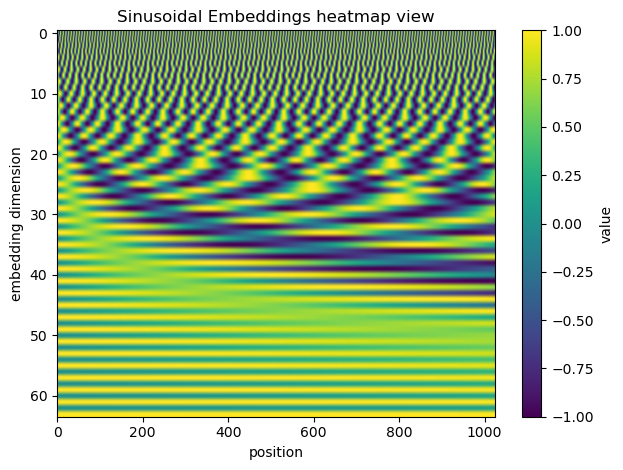

In [37]:
positions = torch.arange(1024)

embeddings = sinusoidal_pos_emb(positions, 64)

visualize_encoding(embeddings)

## Downsample1D
Halves the sequence length with a single 1-D convolution (kernel = 3, stride = 2).

In [ ]:
class Downsample1D(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

## Upsample1D
Doubles the sequence length using a transposed 1-D convolution (kernel = 3, stride = 2).

In [ ]:
class Upsample1D(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

## Conv1DBlock
Basic Conv → BatchNorm → Mish block that keeps sequence length (padding = ker_size // 2).

In [ ]:
class Conv1DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, ker_size):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, ker_size, padding=ker_size//2),
            nn.BatchNorm1d(out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)

## ResidualBlock
Two Conv1DBlocks with FiLM conditioning and a residual skip connection.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, cond_dim, ker_size):
        super().__init__()

        # first conv changes channels; second keeps them
        self.modules = nn.ModuleList([
            Conv1DBlock(in_channels,  out_channels, ker_size),
            Conv1DBlock(out_channels, out_channels, ker_size),
        ])

        # FiLM needs scale + bias for each output channel
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(),                            # non-linearity on condition vector
            nn.Linear(cond_dim, cond_channels),   # map cond_dim -> 2C
            nn.Unflatten(-1, (-1, 1))             # reshape to [B, 2C, 1]
        )

        # match input channels to output for the residual path
        self.residual_conv = (
            nn.Conv1d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels else nn.Identity()
        )

    def forward(self, x, condition):
        # first conv block
        first_out = self.modules[0](x)

        # encode conditioning and split into scale / bias
        embedded_condition = self.cond_encoder(condition).reshape(
            condition.shape[0], 2, self.out_channels, 1
        )
        scale = embedded_condition[:, 0]         # FiLM scale
        bias  = embedded_condition[:, 1]         # FiLM bias

        # apply FiLM: feature-wise affine transform
        out = first_out * scale + bias

        # second conv block
        second_out = self.modules[1](out)

        # residual addition
        out = second_out + self.residual_conv(x)
        return out


## ConditionalUnet1D (Not finished)

In [ ]:
class ConditionalUnet1D(nn.Module):
    def __init__(self, in_channels, cond_dim, diffusion_step_dim=256, down_dims=[256, 512, 1024], ker_size=5):
        super().__init__()

        all_dims = [in_channels] + down_dims + [cond_dim]

        start_dim = down_dims[0]

        diffusion_step_encoder = nn.Sequential(
            SinusoidalPositionalEmbedding(diffusion_step_dim),
            nn.Linear(diffusion_step_dim, diffusion_step_dim * 4),
            nn.Mish(),
            nn.Linear(diffusion_step_dim * 4, diffusion_step_dim)
        )

        cond_dim = cond_dim + diffusion_step_dim


---

## One training / inference step

1. Collect the last $K$ frames, encode each with the visual encoder, aggregate to get $g$.
2. Encode the current diffusion step: $t \rightarrow p_t$.
3. Build the global condition $\text{cond}=[p_t;g]$.
4. Feed the noisy action sequence $a_t$ (reshaped to $(B,2,T)$) through the Conditional U-Net; FiLM layers inject **cond** at every scale.
5. The U-Net outputs $\hat\varepsilon$:

   * **Training:** compute the loss above and update parameters.
   * **Inference:** the scheduler moves $a_t \mapsto a_{t-1}$; repeat until $a_0$ (the clean action trajectory) is produced.

Visual information thus modulates every layer via FiLM, the time embedding tells the network how much noise to remove, and the 1-D convolutional U-Net learns a coherent action sequence of length $\texttt{pred\_horizon}$ conditioned on the observations.
